In [33]:
import os
import pandas as pd
import torch
from torch.utils import data
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.utils.prune as prune

In [158]:
ls

2012.02530.pdf                   iwls2020-lsml-contest/
DL_project_Experiments.ipynb     lut_verilog.aig
DL_Project_Plan_Baleegh.pdf      lut_verilog.v
DL_Project_Proposal_Baleegh.pdf  neuron_to_aig_size.ys
DL_Project_Update_Baleegh.pdf    NN_to_AIG.ipynb


## Training one circuit

In [159]:
# read file from train directory
file_data = open('iwls2020-lsml-contest/benchmarks/train/ex41.train.pla', 'r')
file_data = file_data.readlines()

# preprocess file to separate inputs and outputs
x = []
y = []
for line in file_data:
  if not (line.startswith('.')):
    x.append( line[:line.index(' ')] )
    y.append( line[ line.index(' ')+1:line.index(' ')+2 ] ) 

In [160]:
''' convert data to tensors  '''

# separates string to characters 
def split(word): 
    return [char for char in word] 

for i,input in enumerate(x):
  x[i] = split(input)
  # convert each character to integer
  for j,bit in enumerate(x[i]):
      x[i][j] = int(bit)

features = torch.FloatTensor(x)
y = [int(i) for i in y]
labels = torch.FloatTensor(y)

In [161]:
''' Form a data iterator with batch size 10 '''

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [204]:
''' Setting the neural network '''

class BinaryClassification(nn.Module):
  def __init__(self, input_size=32):
    super(BinaryClassification, self).__init__()
    self.linear1 = nn.Linear(input_size,10)
    self.linear2 = nn.Linear(10,1)

  def forward(self, x):
    x = torch.sigmoid( self.linear1(x) )
    x = torch.sigmoid( self.linear2(x) )
    return x

# instantating the network, loss function and optimizer

net = BinaryClassification(10) # set input size as size of sample

Loss = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [205]:
# print model
print(net)

BinaryClassification(
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)


In [206]:
# define accuracy function

def accuracy(output,labels):
  output = output >=0.5
  acc = torch.sum(output==labels)/len(labels)
  return acc

In [207]:
''' train the model '''

num_epochs = 250
acc_list = []
loss_list = []
for epoch in range(num_epochs):
    for X, y in data_iter:
        output = net(X)
        l = Loss(output, y.reshape(-1,1) )
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    if (epoch%10==0):
      acc = accuracy(net(features), labels.reshape(-1,1))
      l = Loss(net(features), labels.reshape(-1,1))
      acc_list.append(acc)
      loss_list.append(l)
      print(f'epoch {epoch + 1:3d}, loss {l:.3f}, acc {acc:.3f}')

epoch   1, loss 0.694, acc 0.506
epoch  11, loss 0.686, acc 0.588
epoch  21, loss 0.677, acc 0.579
epoch  31, loss 0.673, acc 0.586
epoch  41, loss 0.672, acc 0.587
epoch  51, loss 0.671, acc 0.582
epoch  61, loss 0.670, acc 0.591
epoch  71, loss 0.669, acc 0.590
epoch  81, loss 0.666, acc 0.595
epoch  91, loss 0.660, acc 0.609
epoch 101, loss 0.647, acc 0.630
epoch 111, loss 0.622, acc 0.665
epoch 121, loss 0.590, acc 0.718
epoch 131, loss 0.558, acc 0.744
epoch 141, loss 0.528, acc 0.755
epoch 151, loss 0.499, acc 0.774
epoch 161, loss 0.470, acc 0.787
epoch 171, loss 0.443, acc 0.793
epoch 181, loss 0.419, acc 0.806
epoch 191, loss 0.397, acc 0.822
epoch 201, loss 0.378, acc 0.833
epoch 211, loss 0.361, acc 0.852
epoch 221, loss 0.346, acc 0.859
epoch 231, loss 0.333, acc 0.876
epoch 241, loss 0.322, acc 0.882


## Pruning the NN

In [208]:
# before pruning
print(list(net.named_parameters()))

[('linear1.weight', Parameter containing:
tensor([[ 1.0960e-01,  4.3661e-01,  2.6416e-01,  1.6291e-01, -2.6509e-02,
          7.6564e-02,  6.7869e-02,  1.6099e-01, -8.0609e-02,  4.3602e-02],
        [ 8.3641e-02,  2.9836e-02,  3.5097e-01,  2.2662e-01,  2.0432e+00,
          3.6572e+00, -5.1624e+00,  9.9808e-01,  3.8695e+00, -3.7419e+00],
        [ 1.2418e-01,  2.3284e-01,  2.5562e-01,  9.3909e-01,  1.3750e+00,
          3.3864e+00, -5.3376e+00,  3.6121e+00,  4.4344e+00,  1.4706e+00],
        [ 4.0909e-02,  8.5845e-02, -1.6959e-03, -1.4677e-01, -1.1396e+00,
         -1.1615e+00,  6.7294e-01,  1.5922e+00,  1.2332e+00,  1.1715e+00],
        [ 2.9991e-02,  1.7426e-01,  1.0923e-01, -1.6352e-02, -8.7618e-01,
         -8.1659e-01,  4.5848e-01,  1.3804e+00,  9.7157e-01,  9.8646e-01],
        [-2.8377e-02, -2.1358e-01, -3.0881e-02, -2.1885e-02,  1.3925e+00,
          1.1089e+00, -4.3754e-01, -1.5286e+00, -1.2769e+00, -9.2894e-01],
        [-6.4696e-02, -4.7815e-02,  3.8569e-01,  3.1519e-01, -5.

In [209]:
# prune 

# get max fan in
# max input size : 768, min: 10
# max fan-in = 15

# mapping function: output = output_start + ((output_end - output_start) / (input_end - input_start)) * (input - input_start)
# map [10...768] to [8...12]

input_size = 128
remain_after_pruning = 8 + ( (12-8)/(768-10) )*(input_size-10)
pruning_ratio = (input_size-remain_after_pruning)/input_size

# prune first layer
prune.l1_unstructured(
       net.linear1, 'weight', amount=0.2
    )

prune.ln_structured(
       net.linear1, 'weight', amount=pruning_ratio, dim=1, n='fro' # sets max fan-in to 12
    )

prune.l1_unstructured(
       net.linear1, 'weight', amount=0.3
    )

# prune second layer
prune.ln_structured(
       net.linear2, 'weight', amount=0.2, dim=1, n='fro'
    )

# parameters_to_prune = (
#     (net.linear1, 'weight'),
#     (net.linear2, 'weight')
# )

# prune.global_unstructured(
#     parameters_to_prune,
#     pruning_method=prune.L1Unstructured,
#     amount=pruning_ratio,
# )

Linear(in_features=10, out_features=1, bias=True)

In [210]:
print(list(net.named_buffers()))

[('linear1.weight_mask', tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])), ('linear2.weight_mask', tensor([[0., 1., 1., 1., 1., 1., 1., 1., 0., 1.]]))]


In [211]:
weight_masks = list(net.named_buffers())

In [212]:
# after pruning
prune.remove(net.linear1, 'weight') # makes pruning permanent
prune.remove(net.linear2, 'weight') # makes pruning permanent


Linear(in_features=10, out_features=1, bias=True)

In [213]:
print(list(net.named_parameters()))

[('linear1.bias', Parameter containing:
tensor([-0.2295, -1.7540, -2.1298,  0.5336,  0.3105, -0.8131,  0.3295, -1.1484,
        -0.1051, -0.8901], requires_grad=True)), ('linear1.weight', Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
         -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -5.1624,  0.0000,
          0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -5.3376,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.6729,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.4585,  0.0000,
          0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000],
        [-0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.0000, -0.0000, 

In [214]:
print(list(net.named_buffers()))

[]


## NN --> AIG 

### Neuron -> LUT

In [242]:
neurons = [] # each element is a neuron with a weight vector and a bias scalar
weights = [] # each element is the weight matrix of a layer
biases  = [] # each element contains biases for that layer
for name, param in net.named_parameters():
    if '.weight'in name:
        weights.append( param.detach().numpy() )
    if '.bias' in name:
        biases.append( param.detach().numpy() )

In [243]:
weights

[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
          0.        ,  0.        ,  0.        , -0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        , -5.1623898 ,  0.        ,  0.        , -0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        , -5.337557  ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.        , -0.        , -0.        ,
         -0.        ,  0.67293656,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -0.        , -0.        ,
         -0.        ,  0.458483  ,  0.        ,  0.        ,  0.        ],
        [-0.        , -0.        , -0.        , -0.        ,  0.        ,
          0.        , -0.        , -0.        , -0.        , -0.        ],
        [-0.        , -0.        ,  0.        ,  0.        , -0.        ,
         -0.        , -0.       

In [244]:
weights.reverse()
biases.reverse()
ignore_neurons = [] # element in list: (i,j) neuron j in layer i
for i,layer_weights in enumerate(weights): # i = layer (starting from highest)
    
    # check which neurons in lower layer can be ignored
    for k in range( len(layer_weights[0]) ):
        if( len( np.nonzero(layer_weights[:,k])[0] )==0 ):
            ignore_neurons.append( (i+1,k) )
    
    for j,weight_vector in enumerate(layer_weights): # j = neuron in layer i
        
        if not (i,j) in ignore_neurons:
            neurons.append((weight_vector,biases[i][j]))
                

In [133]:
# get_lut_y
def get_lut_y(input_size,w,b):
    
    lut_y = np.zeros( (pow(2,input_size)), dtype=bool )
    
    input_vector = np.zeros( (input_size) )
    
    for idx in range ( pow(2,input_size) ):
        
#         print(idx)
#         print("input vector: ", input_vector)
        
        #get entry in LUT
        out = input_vector.dot(w) + b
        lut_y[idx] = 1/(1 + np.exp(-out)) >=0.5
        
        # increment input vector
        for i in range(len(input_vector)-1, -1, -1):
            if input_vector[i] == 0:
                input_vector[i] = 1
                break
            input_vector[i] = 0
    
    return lut_y

In [56]:
for neuron in neurons: 
    '''form LUT for each neuron'''
    w = neuron[0]
    b = neuron[1]
    w = w[w.nonzero()]
    input_size = len(w)
    
    print(w)
    print(b)
    print(input_size)
    
    lut_y = get_lut_y(input_size, w, b)
    
#     print( np.shape(lut_y) )
#     print(lut_y[:10])
    
    break

[-0.18343121 -0.168278    2.5306463   1.9195784  -0.70866174 -2.5188968
 -1.9900677  -1.3493629 ]
-1.2743713
8
(256,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [60]:
print(len(lut_y))
print(lut_y[:10])

1
[False]


### LUT --> Verilog

In [58]:
'''create text for verilog file representing LUT'''

n=input_size

file_string ='module lut_verilog(\ninput wire['+str(input_size-1)+':0] in,\noutput reg out\n);\n\nalways@(in) begin\ncase(in)\n'

input_vector = np.zeros( (input_size) )
for idx in range ( pow(2,input_size) ):
    # add to file string
    file_string += str(input_size)+'\'b'+''.join(str(int(e)) for e in input_vector)+' : out = '+str(int(lut_y[idx]))+';\n'
    # increment input vector
    for i in range(len(input_vector)-1, -1, -1):
        if input_vector[i] == 0:
            input_vector[i] = 1
            break
        input_vector[i] = 0

file_string+='endcase\nend\nendmodule\n'

In [59]:
print(file_string)

module lut_verilog(
input wire[7:0] in,
output reg out
);

always@(in) begin
case(in)
8'b00000000 : out = 0;
8'b00000001 : out = 0;
8'b00000010 : out = 0;
8'b00000011 : out = 0;
8'b00000100 : out = 0;
8'b00000101 : out = 0;
8'b00000110 : out = 0;
8'b00000111 : out = 0;
8'b00001000 : out = 0;
8'b00001001 : out = 0;
8'b00001010 : out = 0;
8'b00001011 : out = 0;
8'b00001100 : out = 0;
8'b00001101 : out = 0;
8'b00001110 : out = 0;
8'b00001111 : out = 0;
8'b00010000 : out = 1;
8'b00010001 : out = 0;
8'b00010010 : out = 0;
8'b00010011 : out = 0;
8'b00010100 : out = 0;
8'b00010101 : out = 0;
8'b00010110 : out = 0;
8'b00010111 : out = 0;
8'b00011000 : out = 0;
8'b00011001 : out = 0;
8'b00011010 : out = 0;
8'b00011011 : out = 0;
8'b00011100 : out = 0;
8'b00011101 : out = 0;
8'b00011110 : out = 0;
8'b00011111 : out = 0;
8'b00100000 : out = 1;
8'b00100001 : out = 0;
8'b00100010 : out = 0;
8'b00100011 : out = 0;
8'b00100100 : out = 0;
8'b00100101 : out = 0;
8'b00100110 : out = 0;
8'b00100111 : out

### Verilog LUT --> AIG

#### On the verilog file run the following commands:

read_verilog lut_<>.v

synth -flatten -top g <top_module>

aigmap

write_aiger lut_<>.aig


get first line of lut_<>.aig : aig xxxx xx x x xxxx

get the first number after aig <-- number of and gates

In [87]:
cmd = "yosys neuron_to_aig_size.ys"
os.system(cmd)


 /----------------------------------------------------------------------------\
 |                                                                            |
 |  yosys -- Yosys Open SYnthesis Suite                                       |
 |                                                                            |
 |  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |
 |                                                                            |
 |  Permission to use, copy, modify, and/or distribute this software for any  |
 |  purpose with or without fee is hereby granted, provided that the above    |
 |  copyright notice and this permission notice appear in all copies.         |
 |                                                                            |
 |  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |
 |  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |
 |  MERCHANTABILITY AND FITNESS. IN NO 

Finding identical cells in module `\lut_verilog'.
<suppressed ~6360 debug messages>
Removed a total of 2120 cells.

2.22.3. Executing OPT_DFF pass (perform DFF optimizations).

2.22.4. Executing OPT_CLEAN pass (remove unused cells and wires).
Finding unused cells or wires in module \lut_verilog..
Removed 0 unused cells and 1695 unused wires.
<suppressed ~1 debug messages>

2.22.5. Finished fast OPT passes.

2.23. Executing ABC pass (technology mapping using ABC).

2.23.1. Extracting gate netlist of module `\lut_verilog' to `<abc-temp-dir>/input.blif'..
Extracted 704 gates and 712 wires to a netlist network with 8 inputs and 1 outputs.

2.23.1.1. Executing ABC.
Running ABC command: <yosys-exe-dir>/yosys-abc -s -f <abc-temp-dir>/abc.script 2>&1
ABC: ABC command line: "source <abc-temp-dir>/abc.script".
ABC: 
ABC: + read_blif <abc-temp-dir>/input.blif 
ABC: + read_library <abc-temp-dir>/stdcells.genlib 
ABC: Entered genlib library with 13 gates from file "<abc-temp-dir>/stdcells.genlib".


0

get size of aig from lut_verilog.aig

In [91]:
f = open("lut_verilog.aig", "r")
line = f.readline()

In [99]:
num_and_gates = line.split(' ')[5].split('\n')[0]

In [100]:
num_and_gates

'479'

### NN -> Size of AIG

In [150]:
# model after pruning
print(list(net.named_parameters()))

[('linear1.bias', Parameter containing:
tensor([ 0.0115, -0.0297, -0.0472,  0.1345,  0.0106, -0.0527,  0.0350, -0.0378,
         0.0463,  0.1565], requires_grad=True)), ('linear1.weight', Parameter containing:
tensor([[0., -0., 0.,  ..., -0., -0., -0.],
        [-0., 0., 0.,  ..., -0., 0., -0.],
        [-0., -0., 0.,  ..., -0., -0., 0.],
        ...,
        [-0., -0., -0.,  ..., -0., 0., 0.],
        [0., -0., -0.,  ..., -0., 0., 0.],
        [0., -0., 0.,  ..., 0., -0., 0.]], requires_grad=True)), ('linear2.bias', Parameter containing:
tensor([-0.0186], requires_grad=True)), ('linear2.weight', Parameter containing:
tensor([[-1.3229, -0.6032, -0.0000,  0.7034,  0.8241, -0.0000, -0.3962, -0.8190,
          0.4833,  0.8182]], requires_grad=True))]


In [151]:
# get list of neurons in NN

neurons = [] # each element is a neuron with a weight vector and a bias scalar
weights = [] # each element is the weight matrix of a layer
biases  = [] # each element contains biases for that layer
for name, param in net.named_parameters():
    if '.weight'in name:
        weights.append( param.detach().numpy() )
    if '.bias' in name:
        biases.append( param.detach().numpy() )
        
for i,layer_weights in enumerate(weights): # i = layer
    for j,weight_vector in enumerate(layer_weights): # j = neuron in layer i
        neurons.append((weight_vector,biases[i][j]))
        


In [152]:
size_aig = 0

for neuron in neurons: 
    
    '''form LUT for each neuron'''
    w = neuron[0]
    b = neuron[1]
    w = w[w.nonzero()]
    input_size = len(w)
    
    # get the LUT
    lut_y = get_lut_y(input_size, w, b)
    
    
    '''create text for verilog file representing LUT'''
    n=input_size
    print(input_size)

    file_string ='module lut_verilog(\ninput wire['+str(input_size-1)+':0] in,\noutput reg out\n);\n\nalways@(in) begin\ncase(in)\n'

    input_vector = np.zeros( (input_size) )
    for idx in range ( pow(2,input_size) ):
        # add to file string
        file_string += str(input_size)+'\'b'+''.join(str(int(e)) for e in input_vector)+' : out = '+str(int(lut_y[idx]))+';\n'
        # increment input vector
        for i in range(len(input_vector)-1, -1, -1):
            if input_vector[i] == 0:
                input_vector[i] = 1
                break
            input_vector[i] = 0

    file_string+='endcase\nend\nendmodule\n'
    
    
    '''write to verilog file'''
    f = open("lut_verilog.v", "w")
    f.write(file_string)
    f.close()
    
    
    '''produce the .aig file using yosys script'''
    cmd = "yosys neuron_to_aig_size.ys >/dev/null 2>&1"
    os.system(cmd)
    
    
    '''get the number of and gates in aig and add to the running sum'''
    f = open("lut_verilog.aig", "r")
    line = f.readline()
    size_aig = size_aig + int(line.split(' ')[5].split('\n')[0])
    print("size: ", line.split(' ')[5].split('\n')[0] )
    print("running sum: ",size_aig)

11
size:  4407
running sum:  4407
9
size:  1242
running sum:  5649
4
size:  0
running sum:  5649
6
size:  149
running sum:  5798
9
size:  994
running sum:  6792
0
size:  994
running sum:  7786
5
size:  50
running sum:  7836
9
size:  1250
running sum:  9086
8
size:  513
running sum:  9599
8
size:  487
running sum:  10086
8
size:  332
running sum:  10418


In [28]:
results = [('ex00', 32, 0.5079687237739563, 424), ('ex01', 32, 0.937498927116394, 807), ('ex02', 64, 0.5070310831069946, 213), ('ex03', 64, 0.7887492775917053, 932), ('ex04', 128, 0.5089061260223389, 173), ('ex05', 128, 0.8073423504829407, 1288), ('ex06', 256, 0.4951561987400055, 592), ('ex07', 256, 0.6717190146446228, 2201), ('ex08', 512, 0.5, 2503), ('ex09', 512, 0.5049999952316284, 3809), ('ex10', 32, 0.6587504744529724, 1317), ('ex11', 64, 0.6632817983627319, 1430), ('ex12', 128, 0.6528134942054749, 983), ('ex13', 256, 0.6445316076278687, 1476), ('ex14', 512, 0.6585946679115295, 5021), ('ex15', 32, 0.4946872591972351, 892), ('ex16', 64, 0.7410939335823059, 1998), ('ex17', 128, 0.49406275153160095, 2098), ('ex18', 256, 0.4899999499320984, 1954), ('ex19', 512, 0.49734362959861755, 3527), ('ex20', 16, 0.4968748092651367, 313), ('ex21', 16, 0.5075001120567322, 186), ('ex22', 32, 0.5014060735702515, 33), ('ex23', 32, 0.5015626549720764, 134), ('ex24', 64, 0.503437340259552, 144), ('ex25', 64, 0.5010939836502075, 157), ('ex26', 128, 0.4996875822544098, 149), ('ex27', 128, 0.5101560354232788, 198), ('ex28', 256, 0.5046876072883606, 678), ('ex29', 256, 0.5078125, 662), ('ex30', 20, 0.9414055943489075, 419), ('ex31', 40, 0.9531248211860657, 1314), ('ex32', 60, 0.7974989414215088, 872), ('ex33', 80, 0.7918737530708313, 1333), ('ex34', 100, 0.504843533039093, 1376), ('ex35', 120, 0.5017188787460327, 876), ('ex36', 140, 0.7356252074241638, 1302), ('ex37', 160, 0.8126554489135742, 1095), ('ex38', 180, 0.645469069480896, 1245), ('ex39', 200, 0.6748441457748413, 1720), ('ex40', 16, 0.5021877884864807, 66), ('ex41', 10, 0.5821877717971802, 85), ('ex42', 32, 0.5007809400558472, 174), ('ex43', 18, 0.5023436546325684, 226), ('ex44', 64, 0.4989061951637268, 242), ('ex45', 34, 0.4895310401916504, 148), ('ex46', 128, 0.505937397480011, 72), ('ex47', 66, 0.5007813572883606, 287), ('ex48', 256, 0.4834372103214264, 886), ('ex49', 130, 0.4957813620567322, 391), ('ex50', 19, 0.5525004863739014, 152), ('ex51', 44, 0.5146876573562622, 418), ('ex52', 59, 0.5998443961143494, 452), ('ex53', 45, 0.7521870136260986, 434), ('ex54', 48, 0.7574991583824158, 632), ('ex55', 42, 0.5773441791534424, 436), ('ex56', 83, 0.910936713218689, 1289), ('ex57', 24, 0.18484333157539368, 202), ('ex58', 80, 0.7604680061340332, 728), ('ex59', 394, 0.5225000977516174, 2377), ('ex60', 43, 0.680469274520874, 950), ('ex61', 37, 0.7514058351516724, 586), ('ex62', 52, 0.851248562335968, 1096), ('ex63', 38, 0.8873423337936401, 684), ('ex64', 47, 0.8873424530029297, 491), ('ex65', 19, 0.7584373950958252, 435), ('ex66', 47, 0.7898426651954651, 731), ('ex67', 46, 0.7809368371963501, 797), ('ex68', 33, 0.8792176246643066, 647), ('ex69', 16, 0.9460933804512024, 371), ('ex70', 23, 0.8728114366531372, 375), ('ex71', 23, 0.8998425602912903, 598), ('ex72', 35, 0.24999991059303284, 513), ('ex73', 16, 0.6410942673683167, 207), ('ex74', 16, 0.5117186903953552, 45), ('ex75', 16, 0.3946872353553772, 71), ('ex76', 16, 0.7931239604949951, 149), ('ex77', 16, 0.793123722076416, 134), ('ex78', 16, 0.6417196989059448, 44), ('ex79', 16, 0.7931238412857056, 139), ('ex80', 196, 0.4875001013278961, 1876), ('ex81', 196, 0.4912498891353607, 1417), ('ex82', 196, 0.47921842336654663, 1409), ('ex83', 196, 0.513593852519989, 1165), ('ex84', 196, 0.47562485933303833, 2064), ('ex85', 196, 0.49359384179115295, 1777), ('ex86', 196, 0.524374783039093, 1825), ('ex87', 196, 0.4987502098083496, 1135), ('ex88', 196, 0.4817185401916504, 1907), ('ex89', 196, 0.4884374141693115, 1726), ('ex90', 768, 0.5035936236381531, 6977), ('ex91', 768, 0.5189059972763062, 6811), ('ex92', 768, 0.5034374594688416, 11745), ('ex93', 768, 0.5064063668251038, 8845), ('ex94', 768, 0.5104693174362183, 7061), ('ex95', 768, 0.49312496185302734, 8751), ('ex96', 768, 0.5021876692771912, 10091), ('ex97', 768, 0.506250262260437, 9984), ('ex98', 768, 0.4985935688018799, 8717), ('ex99', 768, 0.5035935640335083, 8203)]

In [29]:
# Analysis
ids = np.asarray([res[0] for res in results])
input_sizes = np.asarray([res[1] for res in results])
acc = np.asarray([res[2] for res in results])
aig_sizes = np.asarray([res[3] for res in results])

avg_accuracy = np.sum(acc)/len(acc)
print("overall accuracy across 100 benchmarks= ", avg_accuracy*100, " %")

size_exceeded = np.where( aig_sizes>5000 )[0]
size_satisfied = np.where( aig_sizes<=5000 )[0]

print(str(len(size_exceeded)), "networks exceeded size constraint:" )
print( ids[size_exceeded] )

avg_accuracy_pass = np.sum(acc[size_satisfied])/len(acc[size_satisfied])
print("overall accuracy across benchmarks under size constraints= ", avg_accuracy_pass*100, " %")

overall accuracy across 100 benchmarks=  60.59670150279999  %
11 networks exceeded size constraint:
['ex14' 'ex90' 'ex91' 'ex92' 'ex93' 'ex94' 'ex95' 'ex96' 'ex97' 'ex98'
 'ex99']
overall accuracy across benchmarks under size constraints=  61.67589218428965  %


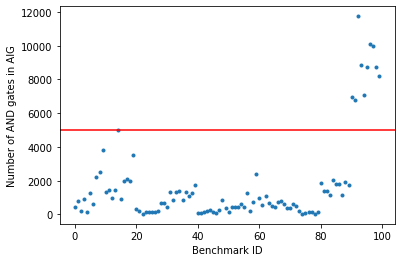

In [32]:
plt.plot(aig_sizes, '.')
plt.ylabel('Number of AND gates in AIG')
plt.xlabel('Benchmark ID')
plt.axhline(y=5000, color='r', linestyle='-')

In [73]:
# Varying circuit constraint analysis

results_1a = [('ex00', 32, 0.5146874785423279, 746), ('ex01', 32, 0.933906078338623, 833), ('ex02', 64, 0.5320314168930054, 1834), ('ex03', 64, 0.899686336517334, 1811), ('ex04', 128, 0.5065627694129944, 4196), ('ex05', 128, 0.9406243562698364, 1480), ('ex06', 256, 0.5460940599441528, 17706), ('ex07', 256, 0.968593418598175, 3359), ('ex08', 512, 0.5090627074241638, 180419), ('ex09', 512, 0.9509369134902954, 44771), ('ex10', 32, 0.798279881477356, 1339), ('ex11', 64, 0.7360932230949402, 1464), ('ex12', 128, 0.6610943675041199, 2468), ('ex13', 256, 0.645156741142273, 3501), ('ex14', 512, 0.6582816243171692, 28840), ('ex15', 32, 0.8281232714653015, 1379), ('ex16', 64, 0.8364049792289734, 3465), ('ex17', 128, 0.7753114104270935, 3559), ('ex18', 256, 0.6401569843292236, 7443), ('ex19', 512, 0.8251544237136841, 29426), ('ex20', 16, 0.5125001668930054, 468), ('ex21', 16, 0.5309373140335083, 560), ('ex22', 32, 0.49859386682510376, 479), ('ex23', 32, 0.5295314788818359, 510), ('ex24', 64, 0.5250004529953003, 1075), ('ex25', 64, 0.5065627098083496, 866), ('ex26', 128, 0.53578120470047, 3512), ('ex27', 128, 0.4903126657009125, 4252), ('ex28', 256, 0.5429688692092896, 15794), ('ex29', 256, 0.5259374976158142, 13754), ('ex30', 20, 0.9374991655349731, 683), ('ex31', 40, 0.9679688215255737, 1385), ('ex32', 60, 0.9346866607666016, 805), ('ex33', 80, 0.9857813715934753, 2434), ('ex34', 100, 0.9687497019767761, 2041), ('ex35', 120, 0.970624566078186, 1770), ('ex36', 140, 0.9823437929153442, 2002), ('ex37', 160, 0.9701560735702515, 3013), ('ex38', 180, 0.9435935020446777, 2881), ('ex39', 200, 0.9718747138977051, 2237), ('ex40', 16, 0.5432815551757812, 380), ('ex41', 10, 0.6075006127357483, 754), ('ex42', 32, 0.528906524181366, 787), ('ex43', 18, 0.5210939645767212, 639), ('ex44', 64, 0.5295316576957703, 1524), ('ex45', 34, 0.5214067697525024, 791), ('ex46', 128, 0.5337501764297485, 2131), ('ex47', 66, 0.513750433921814, 856), ('ex48', 256, 0.528906524181366, 12667), ('ex49', 130, 0.5198441743850708, 2071), ('ex50', 19, 0.7932802438735962, 988), ('ex51', 44, 0.5106251239776611, 2100), ('ex52', 59, 0.595625638961792, 1484), ('ex53', 45, 0.7521874904632568, 1219), ('ex54', 48, 0.7521868944168091, 1148), ('ex55', 42, 0.8315609693527222, 504), ('ex56', 83, 0.6192189455032349, 2029), ('ex57', 24, 0.9676566123962402, 429), ('ex58', 80, 0.8768739700317383, 1542), ('ex59', 394, 0.6692193150520325, 12793), ('ex60', 43, 0.7682810425758362, 1816), ('ex61', 37, 0.7579684853553772, 989), ('ex62', 52, 0.8782796859741211, 1574), ('ex63', 38, 0.8879672288894653, 1135), ('ex64', 47, 0.9506245851516724, 1054), ('ex65', 19, 0.7746871709823608, 1245), ('ex66', 47, 0.7760927677154541, 1247), ('ex67', 46, 0.7404682636260986, 1206), ('ex68', 33, 0.9443745613098145, 1058), ('ex69', 16, 0.9343745112419128, 524), ('ex70', 23, 0.9335931539535522, 872), ('ex71', 23, 0.9189052581787109, 717), ('ex72', 35, 0.8815611600875854, 625), ('ex73', 16, 0.6075009107589722, 1103), ('ex74', 16, 0.5117185711860657, 376), ('ex75', 16, 0.3946872651576996, 263), ('ex76', 16, 0.793123722076416, 1013), ('ex77', 16, 0.7931236028671265, 853), ('ex78', 16, 0.6417192816734314, 479), ('ex79', 16, 0.7931238412857056, 981), ('ex80', 196, 0.5768752098083496, 3315), ('ex81', 196, 0.7396873235702515, 4352), ('ex82', 196, 0.8343733549118042, 6597), ('ex83', 196, 0.8339049220085144, 4939), ('ex84', 196, 0.7879678010940552, 13012), ('ex85', 196, 0.5296874046325684, 7323), ('ex86', 196, 0.5348438024520874, 8226), ('ex87', 196, 0.7910926938056946, 3942), ('ex88', 196, 0.8290611505508423, 12914), ('ex89', 196, 0.7828117609024048, 10836), ('ex90', 768, 0.5201565027236938, 375187), ('ex91', 768, 0.5110938549041748, 476028), ('ex92', 768, 0.5476566553115845, 474636), ('ex93', 768, 0.5317188501358032, 661743), ('ex94', 768, 0.553750216960907, 1017241), ('ex95', 768, 0.5987504720687866, 550106), ('ex96', 768, 0.5248436331748962, 148062), ('ex97', 768, 0.5040621757507324, 458732), ('ex98', 768, 0.4987497329711914, 396343), ('ex99', 768, 0.5329688787460327, 209708)]
results_1b = [('ex00', 32, 0.5176563262939453, 1436), ('ex01', 32, 0.906092643737793, 2233), ('ex02', 64, 0.49734368920326233, 1729), ('ex03', 64, 0.9032794833183289, 2190), ('ex04', 128, 0.5153126120567322, 3132), ('ex05', 128, 0.9685938954353333, 3181), ('ex06', 256, 0.5140624642372131, 7023), ('ex07', 256, 0.9103110432624817, 4307), ('ex08', 512, 0.5026563405990601, 18413), ('ex09', 512, 0.9607809782028198, 15313), ('ex10', 32, 0.7643742561340332, 2987), ('ex11', 64, 0.7874990105628967, 2492), ('ex12', 128, 0.6890629529953003, 3192), ('ex13', 256, 0.7262504696846008, 6595), ('ex14', 512, 0.6890632510185242, 15443), ('ex15', 32, 0.8315606117248535, 2357), ('ex16', 64, 0.8367172479629517, 2627), ('ex17', 128, 0.8249982595443726, 6156), ('ex18', 256, 0.8279672861099243, 7669), ('ex19', 512, 0.8249987363815308, 30895), ('ex20', 16, 0.5104687213897705, 1444), ('ex21', 16, 0.5153126120567322, 1796), ('ex22', 32, 0.5107811689376831, 1745), ('ex23', 32, 0.5160935521125793, 1814), ('ex24', 64, 0.5287504196166992, 1614), ('ex25', 64, 0.5607814788818359, 1506), ('ex26', 128, 0.5315622091293335, 4107), ('ex27', 128, 0.5164063572883606, 3818), ('ex28', 256, 0.4984373152256012, 6032), ('ex29', 256, 0.5592191815376282, 7781), ('ex30', 20, 0.9745312929153442, 2367), ('ex31', 40, 0.9668750762939453, 2055), ('ex32', 60, 0.967343807220459, 2193), ('ex33', 80, 0.9857816696166992, 4330), ('ex34', 100, 0.9682814478874207, 2788), ('ex35', 120, 0.986875057220459, 4262), ('ex36', 140, 0.9595307111740112, 3801), ('ex37', 160, 0.9701560735702515, 3205), ('ex38', 180, 0.971093475818634, 3673), ('ex39', 200, 0.9843748807907104, 4772), ('ex40', 16, 0.5606257319450378, 1432), ('ex41', 10, 0.6029692888259888, 1525), ('ex42', 32, 0.5254688858985901, 1706), ('ex43', 18, 0.515468955039978, 1575), ('ex44', 64, 0.5262499451637268, 2118), ('ex45', 34, 0.5114063024520874, 1551), ('ex46', 128, 0.5235936045646667, 4001), ('ex47', 66, 0.5057810544967651, 1952), ('ex48', 256, 0.5314064621925354, 8287), ('ex49', 130, 0.49874988198280334, 3647), ('ex50', 19, 0.774061918258667, 1949), ('ex51', 44, 0.5234374403953552, 1861), ('ex52', 59, 0.5946879386901855, 2416), ('ex53', 45, 0.6820316910743713, 2872), ('ex54', 48, 0.7740619778633118, 1823), ('ex55', 42, 0.9345302581787109, 1705), ('ex56', 83, 0.5882819294929504, 7258), ('ex57', 24, 0.9623438715934753, 1649), ('ex58', 80, 0.8699983358383179, 3679), ('ex59', 394, 0.6223443746566772, 16849), ('ex60', 43, 0.6579695343971252, 1559), ('ex61', 37, 0.8281232118606567, 2068), ('ex62', 52, 0.873123288154602, 2562), ('ex63', 38, 0.9014051556587219, 1683), ('ex64', 47, 0.9812501668930054, 1949), ('ex65', 19, 0.8723416328430176, 3018), ('ex66', 47, 0.7870307564735413, 2206), ('ex67', 46, 0.7287492156028748, 2225), ('ex68', 33, 0.916405200958252, 2598), ('ex69', 16, 0.9017173647880554, 1594), ('ex70', 23, 0.9317178726196289, 2769), ('ex71', 23, 0.8860921859741211, 1987), ('ex72', 35, 0.8799988031387329, 1887), ('ex73', 16, 0.6187508702278137, 2578), ('ex74', 16, 0.5173437595367432, 1529), ('ex75', 16, 0.3946871757507324, 678), ('ex76', 16, 0.7931240200996399, 1465), ('ex77', 16, 0.7931236624717712, 1843), ('ex78', 16, 0.6417193412780762, 1835), ('ex79', 16, 0.8024986386299133, 1649), ('ex80', 196, 0.5635939836502075, 5242), ('ex81', 196, 0.7490622997283936, 5066), ('ex82', 196, 0.7940613031387329, 4102), ('ex83', 196, 0.7487496137619019, 4793), ('ex84', 196, 0.7779676914215088, 7035), ('ex85', 196, 0.7926556468009949, 7079), ('ex86', 196, 0.6098448038101196, 5190), ('ex87', 196, 0.7570306658744812, 4454), ('ex88', 196, 0.813904881477356, 6018), ('ex89', 196, 0.7662494778633118, 5782), ('ex90', 768, 0.5042189955711365, 70012)]
results_2a = [('ex00', 32, 0.5079687237739563, 424), ('ex01', 32, 0.937498927116394, 807), ('ex02', 64, 0.5070310831069946, 213), ('ex03', 64, 0.7887492775917053, 932), ('ex04', 128, 0.5089061260223389, 173), ('ex05', 128, 0.8073423504829407, 1288), ('ex06', 256, 0.4951561987400055, 592), ('ex07', 256, 0.6717190146446228, 2201), ('ex08', 512, 0.5, 2503), ('ex09', 512, 0.5049999952316284, 3809), ('ex10', 32, 0.6587504744529724, 1317), ('ex11', 64, 0.6632817983627319, 1430), ('ex12', 128, 0.6528134942054749, 983), ('ex13', 256, 0.6445316076278687, 1476), ('ex14', 512, 0.6585946679115295, 5021), ('ex15', 32, 0.4946872591972351, 892), ('ex16', 64, 0.7410939335823059, 1998), ('ex17', 128, 0.49406275153160095, 2098), ('ex18', 256, 0.4899999499320984, 1954), ('ex19', 512, 0.49734362959861755, 3527), ('ex20', 16, 0.4968748092651367, 313), ('ex21', 16, 0.5075001120567322, 186), ('ex22', 32, 0.5014060735702515, 33), ('ex23', 32, 0.5015626549720764, 134), ('ex24', 64, 0.503437340259552, 144), ('ex25', 64, 0.5010939836502075, 157), ('ex26', 128, 0.4996875822544098, 149), ('ex27', 128, 0.5101560354232788, 198), ('ex28', 256, 0.5046876072883606, 678), ('ex29', 256, 0.5078125, 662), ('ex30', 20, 0.9414055943489075, 419), ('ex31', 40, 0.9531248211860657, 1314), ('ex32', 60, 0.7974989414215088, 872), ('ex33', 80, 0.7918737530708313, 1333), ('ex34', 100, 0.504843533039093, 1376), ('ex35', 120, 0.5017188787460327, 876), ('ex36', 140, 0.7356252074241638, 1302), ('ex37', 160, 0.8126554489135742, 1095), ('ex38', 180, 0.645469069480896, 1245), ('ex39', 200, 0.6748441457748413, 1720), ('ex40', 16, 0.5021877884864807, 66), ('ex41', 10, 0.5821877717971802, 85), ('ex42', 32, 0.5007809400558472, 174), ('ex43', 18, 0.5023436546325684, 226), ('ex44', 64, 0.4989061951637268, 242), ('ex45', 34, 0.4895310401916504, 148), ('ex46', 128, 0.505937397480011, 72), ('ex47', 66, 0.5007813572883606, 287), ('ex48', 256, 0.4834372103214264, 886), ('ex49', 130, 0.4957813620567322, 391), ('ex50', 19, 0.5525004863739014, 152), ('ex51', 44, 0.5146876573562622, 418), ('ex52', 59, 0.5998443961143494, 452), ('ex53', 45, 0.7521870136260986, 434), ('ex54', 48, 0.7574991583824158, 632), ('ex55', 42, 0.5773441791534424, 436), ('ex56', 83, 0.910936713218689, 1289), ('ex57', 24, 0.18484333157539368, 202), ('ex58', 80, 0.7604680061340332, 728), ('ex59', 394, 0.5225000977516174, 2377), ('ex60', 43, 0.680469274520874, 950), ('ex61', 37, 0.7514058351516724, 586), ('ex62', 52, 0.851248562335968, 1096), ('ex63', 38, 0.8873423337936401, 684), ('ex64', 47, 0.8873424530029297, 491), ('ex65', 19, 0.7584373950958252, 435), ('ex66', 47, 0.7898426651954651, 731), ('ex67', 46, 0.7809368371963501, 797), ('ex68', 33, 0.8792176246643066, 647), ('ex69', 16, 0.9460933804512024, 371), ('ex70', 23, 0.8728114366531372, 375), ('ex71', 23, 0.8998425602912903, 598), ('ex72', 35, 0.24999991059303284, 513), ('ex73', 16, 0.6410942673683167, 207), ('ex74', 16, 0.5117186903953552, 45), ('ex75', 16, 0.3946872353553772, 71), ('ex76', 16, 0.7931239604949951, 149), ('ex77', 16, 0.793123722076416, 134), ('ex78', 16, 0.6417196989059448, 44), ('ex79', 16, 0.7931238412857056, 139), ('ex80', 196, 0.4875001013278961, 1876), ('ex81', 196, 0.4912498891353607, 1417), ('ex82', 196, 0.47921842336654663, 1409), ('ex83', 196, 0.513593852519989, 1165), ('ex84', 196, 0.47562485933303833, 2064), ('ex85', 196, 0.49359384179115295, 1777), ('ex86', 196, 0.524374783039093, 1825), ('ex87', 196, 0.4987502098083496, 1135), ('ex88', 196, 0.4817185401916504, 1907), ('ex89', 196, 0.4884374141693115, 1726), ('ex90', 768, 0.5035936236381531, 6977), ('ex91', 768, 0.5189059972763062, 6811), ('ex92', 768, 0.5034374594688416, 11745), ('ex93', 768, 0.5064063668251038, 8845), ('ex94', 768, 0.5104693174362183, 7061), ('ex95', 768, 0.49312496185302734, 8751), ('ex96', 768, 0.5021876692771912, 10091), ('ex97', 768, 0.506250262260437, 9984), ('ex98', 768, 0.4985935688018799, 8717), ('ex99', 768, 0.5035935640335083, 8203)]
results_2b = [('ex00', 32, 0.5176563262939453, 1436), ('ex01', 32, 0.906092643737793, 2233), ('ex02', 64, 0.49734368920326233, 1729), ('ex03', 64, 0.9032794833183289, 2190), ('ex04', 128, 0.5153126120567322, 3132), ('ex05', 128, 0.9685938954353333, 3181), ('ex06', 256, 0.5140624642372131, 7023), ('ex07', 256, 0.9103110432624817, 4307), ('ex08', 512, 0.5026563405990601, 18413), ('ex09', 512, 0.9607809782028198, 15313), ('ex10', 32, 0.7643742561340332, 2987), ('ex11', 64, 0.7874990105628967, 2492), ('ex12', 128, 0.6890629529953003, 3192), ('ex13', 256, 0.7262504696846008, 6595), ('ex14', 512, 0.6890632510185242, 15443), ('ex15', 32, 0.8315606117248535, 2357), ('ex16', 64, 0.8367172479629517, 2627), ('ex17', 128, 0.8249982595443726, 6156), ('ex18', 256, 0.8279672861099243, 7669), ('ex19', 512, 0.8249987363815308, 30895), ('ex20', 16, 0.5104687213897705, 1444), ('ex21', 16, 0.5153126120567322, 1796), ('ex22', 32, 0.5107811689376831, 1745), ('ex23', 32, 0.5160935521125793, 1814), ('ex24', 64, 0.5287504196166992, 1614), ('ex25', 64, 0.5607814788818359, 1506), ('ex26', 128, 0.5315622091293335, 4107), ('ex27', 128, 0.5164063572883606, 3818), ('ex28', 256, 0.4984373152256012, 6032), ('ex29', 256, 0.5592191815376282, 7781), ('ex30', 20, 0.9745312929153442, 2367), ('ex31', 40, 0.9668750762939453, 2055), ('ex32', 60, 0.967343807220459, 2193), ('ex33', 80, 0.9857816696166992, 4330), ('ex34', 100, 0.9682814478874207, 2788), ('ex35', 120, 0.986875057220459, 4262), ('ex36', 140, 0.9595307111740112, 3801), ('ex37', 160, 0.9701560735702515, 3205), ('ex38', 180, 0.971093475818634, 3673), ('ex39', 200, 0.9843748807907104, 4772), ('ex40', 16, 0.5606257319450378, 1432), ('ex41', 10, 0.6029692888259888, 1525), ('ex42', 32, 0.5254688858985901, 1706), ('ex43', 18, 0.515468955039978, 1575), ('ex44', 64, 0.5262499451637268, 2118), ('ex45', 34, 0.5114063024520874, 1551), ('ex46', 128, 0.5235936045646667, 4001), ('ex47', 66, 0.5057810544967651, 1952), ('ex48', 256, 0.5314064621925354, 8287), ('ex49', 130, 0.49874988198280334, 3647), ('ex50', 19, 0.774061918258667, 1949), ('ex51', 44, 0.5234374403953552, 1861), ('ex52', 59, 0.5946879386901855, 2416), ('ex53', 45, 0.6820316910743713, 2872), ('ex54', 48, 0.7740619778633118, 1823), ('ex55', 42, 0.9345302581787109, 1705), ('ex56', 83, 0.5882819294929504, 7258), ('ex57', 24, 0.9623438715934753, 1649), ('ex58', 80, 0.8699983358383179, 3679), ('ex59', 394, 0.6223443746566772, 16849), ('ex60', 43, 0.6579695343971252, 1559), ('ex61', 37, 0.8281232118606567, 2068), ('ex62', 52, 0.873123288154602, 2562), ('ex63', 38, 0.9014051556587219, 1683), ('ex64', 47, 0.9812501668930054, 1949), ('ex65', 19, 0.8723416328430176, 3018), ('ex66', 47, 0.7870307564735413, 2206), ('ex67', 46, 0.7287492156028748, 2225), ('ex68', 33, 0.916405200958252, 2598), ('ex69', 16, 0.9017173647880554, 1594), ('ex70', 23, 0.9317178726196289, 2769), ('ex71', 23, 0.8860921859741211, 1987), ('ex72', 35, 0.8799988031387329, 1887), ('ex73', 16, 0.6187508702278137, 2578), ('ex74', 16, 0.5173437595367432, 1529), ('ex75', 16, 0.3946871757507324, 678), ('ex76', 16, 0.7931240200996399, 1465), ('ex77', 16, 0.7931236624717712, 1843), ('ex78', 16, 0.6417193412780762, 1835), ('ex79', 16, 0.8024986386299133, 1649), ('ex80', 196, 0.5635939836502075, 5242), ('ex81', 196, 0.7490622997283936, 5066), ('ex82', 196, 0.7940613031387329, 4102), ('ex83', 196, 0.7487496137619019, 4793), ('ex84', 196, 0.7779676914215088, 7035), ('ex85', 196, 0.7926556468009949, 7079), ('ex86', 196, 0.6098448038101196, 5190), ('ex87', 196, 0.7570306658744812, 4454), ('ex88', 196, 0.813904881477356, 6018), ('ex89', 196, 0.7662494778633118, 5782), ('ex90', 768, 0.5042189955711365, 70012)]
results_3 = [('ex00', 32, 0.9146865606307983, 2808), ('ex01', 32, 0.9359360933303833, 2075), ('ex02', 64, 0.4996872544288635, 2032), ('ex03', 64, 0.9401556253433228, 2112), ('ex04', 128, 0.5045312643051147, 2222), ('ex05', 128, 0.9626563191413879, 4183), ('ex06', 256, 0.5057811737060547, 3566), ('ex07', 256, 0.9521875381469727, 6994), ('ex08', 512, 0.5185939073562622, 13073), ('ex09', 512, 0.9839062690734863, 21015), ('ex10', 32, 0.8589041829109192, 2472), ('ex11', 64, 0.8192172050476074, 2328), ('ex12', 128, 0.7948426008224487, 3210), ('ex13', 256, 0.8292170763015747, 5331), ('ex14', 512, 0.782342791557312, 19413), ('ex15', 32, 0.8998421430587769, 1423), ('ex16', 64, 0.8942174911499023, 1877), ('ex17', 128, 0.741093099117279, 3969), ('ex18', 256, 0.7067192792892456, 5901), ('ex19', 512, 0.8243733644485474, 15585), ('ex20', 16, 0.5103126168251038, 1706), ('ex21', 16, 0.9925001263618469, 1974), ('ex22', 32, 0.5171876549720764, 1839), ('ex23', 32, 1.0, 2081), ('ex24', 64, 0.5109375715255737, 1937), ('ex25', 64, 1.0, 2497), ('ex26', 128, 0.5001562833786011, 1788), ('ex27', 128, 0.5101563930511475, 3681), ('ex28', 256, 0.5090625286102295, 4783), ('ex29', 256, 0.5078126788139343, 4222), ('ex30', 20, 0.9729684591293335, 2140), ('ex31', 40, 0.9696875810623169, 2482), ('ex32', 60, 0.9710938334465027, 2019), ('ex33', 80, 0.981874942779541, 3005), ('ex34', 100, 0.9843751192092896, 3771), ('ex35', 120, 0.9868753552436829, 4005), ('ex36', 140, 0.9831250309944153, 4913), ('ex37', 160, 0.9854687452316284, 5173), ('ex38', 180, 0.9710936546325684, 5506), ('ex39', 200, 0.9862500429153442, 6899), ('ex40', 16, 0.6257820129394531, 1765), ('ex41', 10, 0.9056239128112793, 1833), ('ex42', 32, 0.5123441219329834, 1699), ('ex43', 18, 0.5342187881469727, 1651), ('ex44', 64, 0.519687294960022, 1316), ('ex45', 34, 0.5142184495925903, 1430), ('ex46', 128, 0.504844069480896, 3148), ('ex47', 66, 0.5071873664855957, 1791), ('ex48', 256, 0.48515599966049194, 6776), ('ex49', 130, 0.5034373998641968, 2597), ('ex50', 19, 0.893280029296875, 1849), ('ex51', 44, 0.550312876701355, 1637), ('ex52', 59, 0.6262500286102295, 2206), ('ex53', 45, 0.8012482523918152, 1507), ('ex54', 48, 0.9345303773880005, 1912), ('ex55', 42, 0.9859377145767212, 2356), ('ex56', 83, 0.8735917806625366, 3335), ('ex57', 24, 0.9721872210502625, 2025), ('ex58', 80, 0.9534371495246887, 2989), ('ex59', 394, 0.8182799220085144, 7660), ('ex60', 43, 0.896873950958252, 2460), ('ex61', 37, 0.9967187643051147, 2333), ('ex62', 52, 0.8432797193527222, 2418), ('ex63', 38, 0.9165619611740112, 1974), ('ex64', 47, 0.9812498092651367, 1457), ('ex65', 19, 0.849373459815979, 1940), ('ex66', 47, 0.878436267375946, 1631), ('ex67', 46, 0.8435918688774109, 2278), ('ex68', 33, 0.9242178797721863, 2238), ('ex69', 16, 0.9696876406669617, 1665), ('ex70', 23, 0.9918750524520874, 1978), ('ex71', 23, 0.9943749308586121, 1803), ('ex72', 35, 0.9195305109024048, 2035), ('ex73', 16, 0.6775004267692566, 2342), ('ex74', 16, 0.5326565504074097, 1705), ('ex75', 16, 0.397812157869339, 557), ('ex76', 16, 0.2259373962879181, 1829), ('ex77', 16, 0.22515615820884705, 1382), ('ex78', 16, 0.6417193412780762, 2044), ('ex79', 16, 0.2501562237739563, 1731), ('ex80', 196, 0.6767185926437378, 3195), ('ex81', 196, 0.6976565718650818, 5163), ('ex82', 196, 0.7676557302474976, 5166), ('ex83', 196, 0.4490625262260437, 3823), ('ex84', 196, 0.5925005078315735, 3963), ('ex85', 196, 0.8289044499397278, 4038), ('ex86', 196, 0.621407151222229, 3573), ('ex87', 196, 0.5948439836502075, 4725), ('ex88', 196, 0.5767194032669067, 4193), ('ex89', 196, 0.5256251096725464, 4249), ('ex90', 768, 0.5009377598762512, 23578)]
results_4 = [('ex00', 32, 0.6967187523841858, 3893), ('ex01', 32, 0.9317179918289185, 3345), ('ex02', 64, 0.7504680752754211, 4323), ('ex03', 64, 0.9160928726196289, 4033), ('ex04', 128, 0.5137501955032349, 3319), ('ex05', 128, 0.9671874046325684, 4176), ('ex06', 256, 0.5171875357627869, 5450), ('ex07', 256, 0.9387494325637817, 7999), ('ex08', 512, 0.506250262260437, 10781), ('ex09', 512, 0.9842191934585571, 12781), ('ex10', 32, 0.852811336517334, 4618), ('ex11', 64, 0.8257796168327332, 4650), ('ex12', 128, 0.7937485575675964, 4248), ('ex13', 256, 0.766874372959137, 5571), ('ex14', 512, 0.7571872472763062, 9639), ('ex15', 32, 0.8978112936019897, 4052), ('ex16', 64, 0.8917175531387329, 3395), ('ex17', 128, 0.7814052700996399, 3904), ('ex18', 256, 0.7017187476158142, 5977), ('ex19', 512, 0.5360939502716064, 14567), ('ex20', 16, 0.5235940217971802, 2525), ('ex21', 16, 0.9832812547683716, 3016), ('ex22', 32, 0.5195313692092896, 3529), ('ex23', 32, 1.0, 3897), ('ex24', 64, 0.4960938096046448, 3202), ('ex25', 64, 0.5051563382148743, 1984), ('ex26', 128, 0.5006247162818909, 4268), ('ex27', 128, 1.0, 4072), ('ex28', 256, 0.5001562833786011, 5106), ('ex29', 256, 1.0, 5495), ('ex30', 20, 0.9723436236381531, 2408), ('ex31', 40, 0.9679689407348633, 3133), ('ex32', 60, 0.970000147819519, 3903), ('ex33', 80, 0.9726560711860657, 4622), ('ex34', 100, 0.9659374356269836, 4073), ('ex35', 120, 0.9706252217292786, 4212), ('ex36', 140, 0.9831250309944153, 6847), ('ex37', 160, 0.9854686856269836, 7921), ('ex38', 180, 0.9715625643730164, 6846), ('ex39', 200, 0.9776561856269836, 4864), ('ex40', 16, 0.6123446226119995, 3653), ('ex41', 10, 0.8682795763015747, 2888), ('ex42', 32, 0.5074999928474426, 2691), ('ex43', 18, 0.5456250905990601, 2089), ('ex44', 64, 0.5009373426437378, 3761), ('ex45', 34, 0.5265626311302185, 3702), ('ex46', 128, 0.5040624141693115, 3523), ('ex47', 66, 0.5140625238418579, 3053), ('ex48', 256, 0.5145314335823059, 6002), ('ex49', 130, 0.504218578338623, 4125), ('ex50', 19, 0.8826549649238586, 4101), ('ex51', 44, 0.5628132820129395, 3282), ('ex52', 59, 0.6234382390975952, 3412), ('ex53', 45, 0.7984364628791809, 4348), ('ex54', 48, 0.9407804608345032, 3776), ('ex55', 42, 0.9848435521125793, 3745), ('ex56', 83, 0.8481237292289734, 2711), ('ex57', 24, 0.9803126454353333, 3764), ('ex58', 80, 0.9582813382148743, 4408), ('ex59', 394, 0.5928126573562622, 9604), ('ex60', 43, 0.8924986124038696, 4542), ('ex61', 37, 0.9967187643051147, 5008), ('ex62', 52, 0.8579676747322083, 4236), ('ex63', 38, 0.9328117370605469, 5118), ('ex64', 47, 0.981249988079071, 3000), ('ex65', 19, 0.9392186403274536, 3642), ('ex66', 47, 0.8510920405387878, 3496), ('ex67', 46, 0.8384356498718262, 4986), ('ex68', 33, 0.9060922861099243, 4214), ('ex69', 16, 0.9687502980232239, 3656), ('ex70', 23, 0.9918750524520874, 3640), ('ex71', 23, 0.9943751096725464, 4755), ('ex72', 35, 0.8670296669006348, 3828), ('ex73', 16, 0.659531831741333, 3241), ('ex74', 16, 0.5149997472763062, 2416), ('ex75', 16, 0.39749976992607117, 1010), ('ex76', 16, 0.22281226515769958, 2594), ('ex77', 16, 0.21796849370002747, 1850), ('ex78', 16, 0.6368752717971802, 2739), ('ex79', 16, 0.22499990463256836, 1672), ('ex80', 196, 0.5634379982948303, 9473), ('ex81', 196, 0.7568740844726562, 7756), ('ex82', 196, 0.7396873235702515, 6972), ('ex83', 196, 0.5912501811981201, 9066), ('ex84', 196, 0.4789060652256012, 7243), ('ex85', 196, 0.8015613555908203, 9721), ('ex86', 196, 0.5585938692092896, 8085), ('ex87', 196, 0.8017171621322632, 8356), ('ex88', 196, 0.7706242203712463, 8804), ('ex89', 196, 0.67875075340271, 5171), ('ex90', 768, 0.5274998545646667, 15571)]

size_constraints = np.array([5000, 6000, 7500, 10000,100000, 1e8 ], dtype = int)

def get_acc_sc( results ):
    acc = np.asarray([res[2] for res in results])
    aig_sizes = np.asarray([res[3] for res in results])
    size_constraints = np.array([5000,6000,7000,10000,100000, 1e9 ])
    acc_sc = []
    for size_c in size_constraints:
        size_satisfied = np.where( aig_sizes<=size_c )[0]
        acc_sc.append( np.sum(acc[size_satisfied])/len(acc[size_satisfied]) )
    return acc_sc

acc_1a_sc = get_acc_sc( results_1a )
acc_1b_sc = get_acc_sc( results_1b )
acc_2a_sc = get_acc_sc( results_2a )
acc_2b_sc = get_acc_sc( results_2b )
acc_3_sc = get_acc_sc( results_3 )
acc_4_sc = get_acc_sc( results_4 )

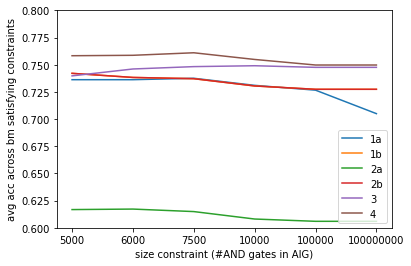

In [75]:
x_array = np.arange(len(size_constraints))
plt.plot(x_array, acc_1a_sc, label = '1a')
plt.plot(x_array, acc_1b_sc, label = '1b')
plt.plot(x_array, acc_2a_sc, label = '2a')
plt.plot(x_array, acc_2b_sc, label = '2b')
plt.plot(x_array, acc_3_sc, label = '3')
plt.plot(x_array, acc_4_sc, label = '4')

plt.xlabel('size constraint (#AND gates in AIG)')
plt.ylabel('avg acc across bm satisfying constraints')
plt.xticks(x_array, size_constraints )
plt.ylim([0.6,0.8])
plt.legend( loc = 'lower right')